In [1]:
import torch
import torch.optim as optim
import numpy as np
import scanpy as sc
import scvelo as scv
from model import NETWORK  # Ensure that model.py is saved in the same directory
from dataloaders import * # Ensure that dataloaders.py is saved in the same directory
from utils import *
from sklearn.manifold import Isomap
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra

# Setup configuration
latent_dim = 64  # Latent dimension size, can be adjusted
hidden_dim = 512  # Hidden dimension size for the encoder and decoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

n_components = 100
n_knn_search = 10
dataset_name = "gastrulation_erythroid"
cell_type_key = "celltype"
model_name = "imVelo"

num_genes = 2000
nhead = 1 #original: 1
embedding_dim = 128*nhead# original: 128
num_encoder_layers = 1 #original: 1
num_bins = 50
batch_size = 64  # Batch size for training
epochs = 10  # Number of epochs for training
learning_rate = 1e-4  # Learning rate for the optimizer
lambda1 = 1e-1  # Weight for heuristic loss
lambda2 = 1 # Weight for discrepancy loss
K = 11  # Number of neighbors for heuristic loss

# Load data
adata = sc.read_h5ad("gastrulation_erythroid.h5ad")
# Initialize model, optimizer, and loss function
model = NETWORK(input_dim=adata.shape[1]*2, latent_dim=latent_dim, 
                hidden_dim=hidden_dim, emb_dim = embedding_dim,
                nhead=nhead, num_encoder_layers=num_encoder_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up data loaders
train_loader, test_loader, full_data_loader = setup_dataloaders_binning(adata, 
                                                                       batch_size=batch_size, 
                                                                       num_genes=num_genes, 
                                                                       embedding_dim=embedding_dim,
                                                                       num_bins=num_bins)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for batch_idx, (tokens, data, batch_indices) in enumerate(full_data_loader):
        tokens = tokens.to(device)
        data = data.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        """print(tokens.shape)
        print(data.shape)
        print(batch_indices.shape)"""
        
        # Forward pass
        out_dic = model(tokens, data)
        
        # Compute loss
        losses_dic = model.heuristic_loss(
            adata=adata, 
            x=data, 
            batch_indices=batch_indices,
            lambda1=lambda1, 
            lambda2=lambda2, 
            out_dic=out_dic, 
            device=device,
            K=K
        )
        
        # Backward pass and optimization
        loss = losses_dic["total_loss"]
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for monitoring
        running_loss += loss.item()
        
        if batch_idx % 10 == 0:  # Print every 10 batches
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}], Loss: {loss.item()}')
    
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss / len(train_loader)}')

    # Save the model periodically
    """if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')"""

# After training, save final model
torch.save(model.state_dict(), 'final_model.pth')
"""
# Test the model on the test set (if available)
if test_loader is not None:
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():
        for inputs, batch_indices in test_loader:
            inputs = inputs.to(device)
            out_dic = model(inputs)
            
            # Compute test loss
            losses_dic = model.heuristic_loss(
                adata=adata, 
                x=inputs, 
                batch_indices=batch_indices,
                lambda1=lambda1, 
                lambda2=lambda2, 
                out_dic=out_dic, 
                device=device,
                K=K
            )
            total_test_loss += losses_dic["total_loss"].item()

    print(f'Test Loss: {total_test_loss / len(test_loader)}')"""

# Initialize empty layers in adata for storing results
adata.layers["velocity_u"] = np.zeros_like(adata.layers["Mu"])  # Initialize for velocity_u
adata.layers["velocity"] = np.zeros_like(adata.layers["Ms"])  # Initialize for velocity (spliced)
adata.layers["pp"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["nn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["pn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["np"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.obsm["pred"] = np.zeros((adata.shape[0], adata.shape[1] * 2))  # Assuming 2*genes for prediction

# Fetch output dictionary for the entire dataset after training and store results in adata layers
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch_idx, (tokens, data, batch_indices) in enumerate(full_data_loader):
        tokens = tokens.to(device)
        data = data.to(device)
        out_dic = model(tokens, data)

        # Store the results in adata layers according to batch_indices
        adata.layers["velocity_u"][batch_indices] = out_dic["v_u"].cpu().numpy()
        adata.layers["velocity"][batch_indices] = out_dic["v_s"].cpu().numpy()
        adata.layers["pp"][batch_indices] = out_dic["pp"].cpu().numpy()
        adata.layers["nn"][batch_indices] = out_dic["nn"].cpu().numpy()
        adata.layers["pn"][batch_indices] = out_dic["pn"].cpu().numpy()
        adata.layers["np"][batch_indices] = out_dic["np"].cpu().numpy()

        # Store predictions in adata.obsm
        adata.obsm["pred"][batch_indices] = out_dic["pred"].cpu().numpy()

print('Results stored in adata.layers and adata.obsm')


Epoch [1/10], Batch [0], Loss: 0.10212156176567078
Epoch [1/10], Batch [10], Loss: 0.053801365196704865
Epoch [1/10], Batch [20], Loss: 0.03749377653002739
Epoch [1/10], Batch [30], Loss: 0.01293492503464222
Epoch [1/10], Batch [40], Loss: 0.023584334179759026
Epoch [1/10], Batch [50], Loss: 0.04416707530617714
Epoch [1/10], Batch [60], Loss: 0.06255850940942764
Epoch [1/10], Batch [70], Loss: 0.02321416512131691
Epoch [1/10], Batch [80], Loss: 0.019737858325242996
Epoch [1/10], Batch [90], Loss: 0.03408297151327133
Epoch [1/10], Batch [100], Loss: 0.023638222366571426
Epoch [1/10], Batch [110], Loss: 0.018781324848532677
Epoch [1/10], Batch [120], Loss: 0.01942252553999424
Epoch [1/10], Batch [130], Loss: 0.016631990671157837
Epoch [1/10], Batch [140], Loss: 0.029209090396761894
Epoch [1/10], Batch [150], Loss: 0.029446789994835854
Epoch [1/10], Average Loss: 0.038240012682241496
Epoch [2/10], Batch [0], Loss: 0.044404536485672
Epoch [2/10], Batch [10], Loss: 0.014005577191710472
Epoc

computing velocity graph (using 1/24 cores)
    finished (0:00:38) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


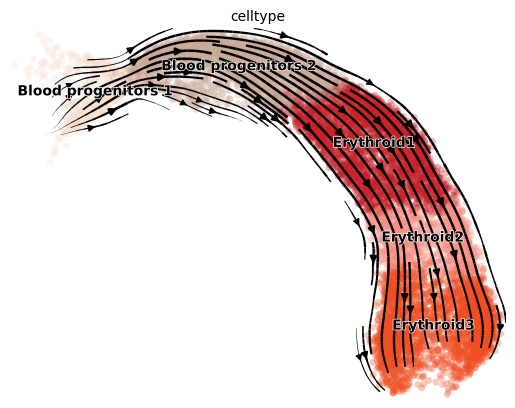

In [6]:
adata.layers["velocity"] *= -1
adata.layers["velocity_u"] *= -1

scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color=cell_type_key)
#scv.tl.velocity_pseudotime(adata)
#sc.pl.umap(adata, color="velocity_pseudotime", cmap="gnuplot")

In [7]:
scv.tl.rank_velocity_genes(adata, groupby=cell_type_key)
import pandas as pd
pd.DataFrame(adata.uns["rank_velocity_genes"]["names"])

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,Blood progenitors 1,Blood progenitors 2,Erythroid1,Erythroid2,Erythroid3
0,Mns1,Hbb-bh1,Redrum,Mlec,Hbb-y
1,Hsp90aa1,Blvrb,Npm1,Ctnnb1,Slc25a4
2,Tspan33,Alad,Hba-x,Krtcap2,Krtcap2
3,Car2,Gypa,Eif4e,Slc25a4,Mlec
4,Klf1,Kcnn4,Eif4a1,Gpr180,Ctnnb1
...,...,...,...,...,...
95,Picalm,Stmn1,Fli1,Fam92a,Rsrp1
96,Ccdc137,Eef1e1,Gpr180,Rsrp1,Rab12
97,Ddx46,Fkbp11,Igf2bp3,Galnt7,Fam92a
98,Rpa2,Suz12,Rbm22,Trim71,Tpm4


Plot saved to plots/plot1.png


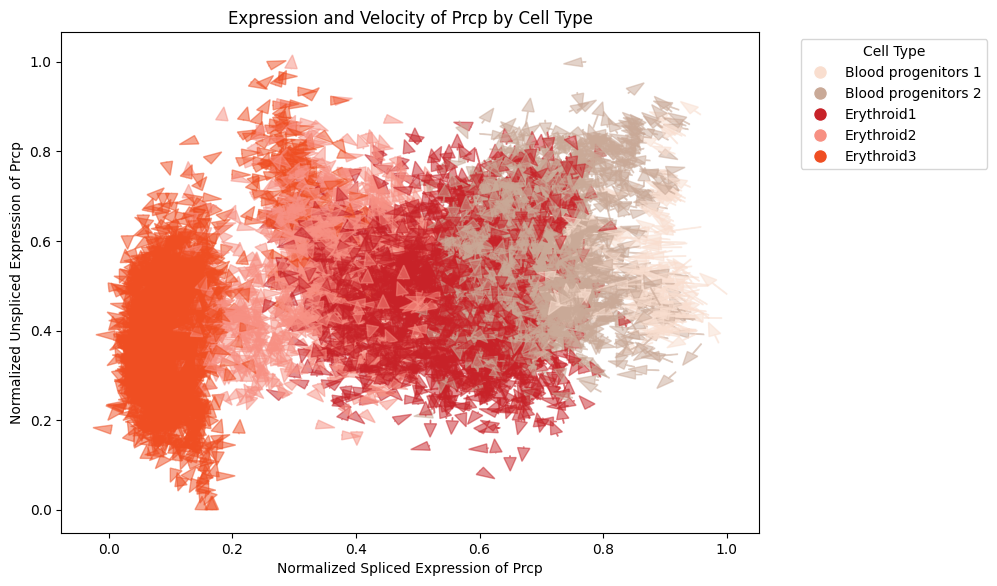

In [8]:
plot_phase_plane(adata, "Prcp", dataset_name, 11, 
                 u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                 save_path="plots/plot1.png")

Plot saved to plots/plot1.png


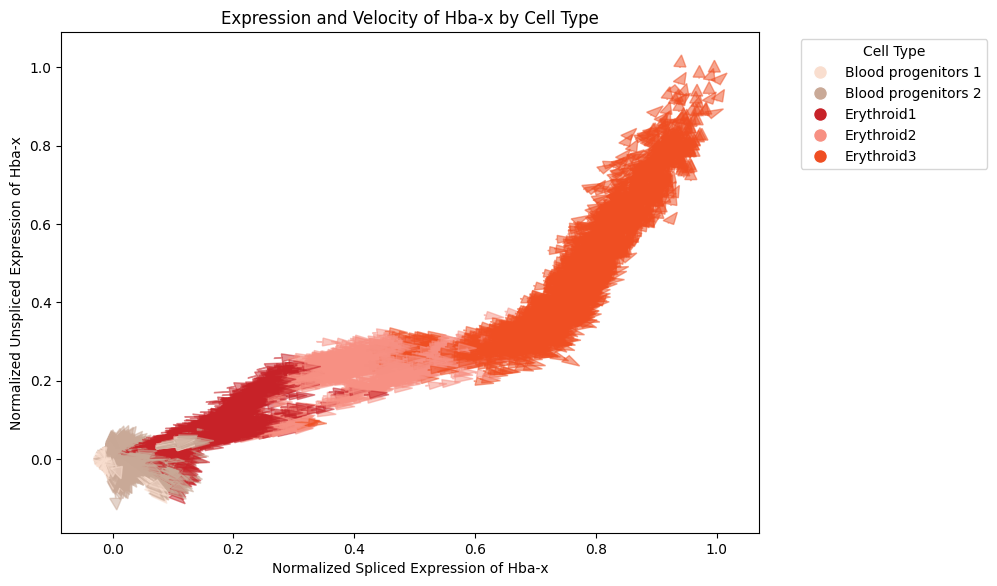

In [9]:
plot_phase_plane(adata, "Hba-x", dataset_name, 11, 
                 u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                 save_path="plots/plot1.png")

Plot saved to plots/plot2.png


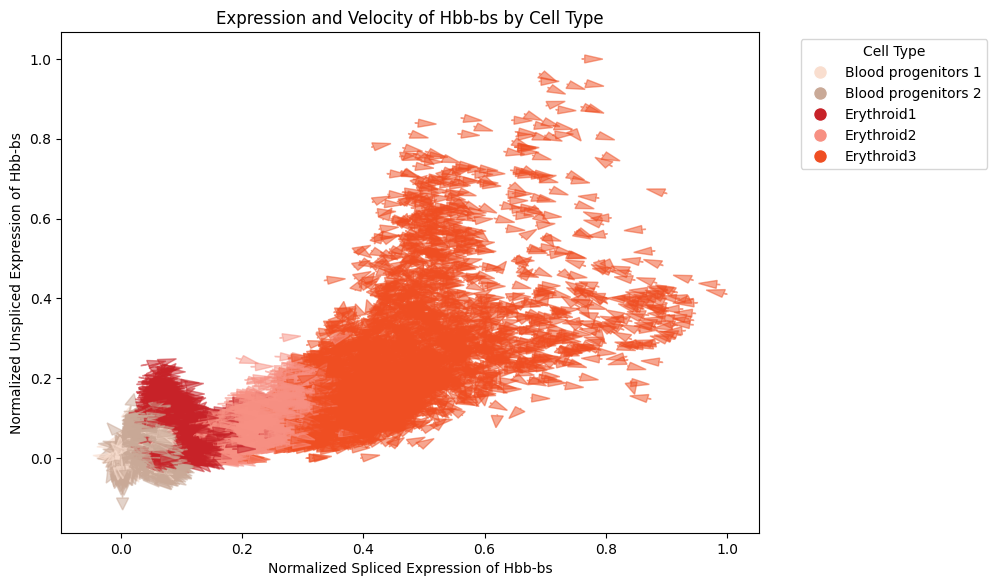

In [10]:
plot_phase_plane(adata, "Hbb-bs", dataset_name, 11, 
                 u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                 save_path="plots/plot2.png")

Plot saved to plots/plot2.png


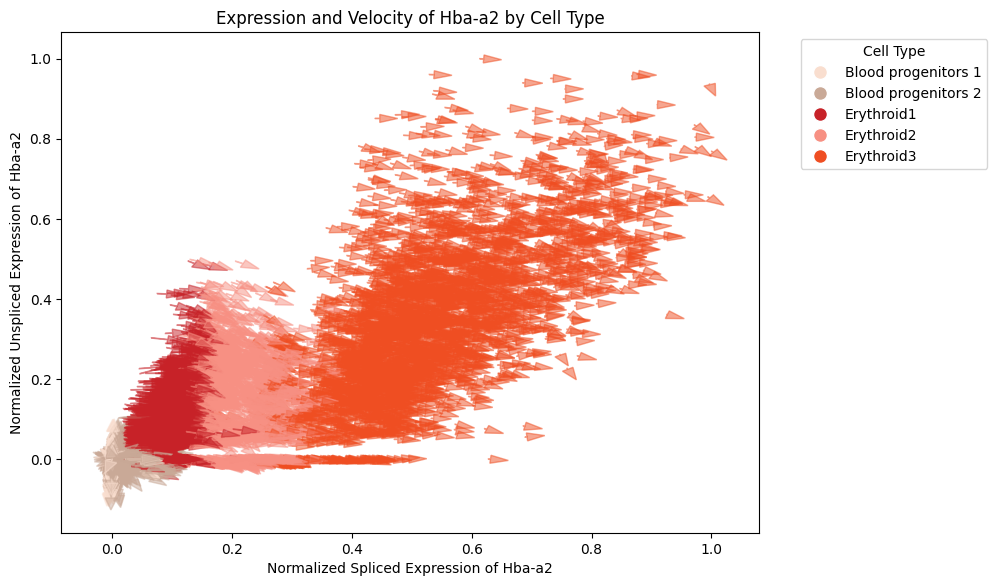

In [11]:
plot_phase_plane(adata, "Hba-a2", dataset_name, 11, 
                 u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                 save_path="plots/plot2.png")

Plot saved to plots/plot2.png


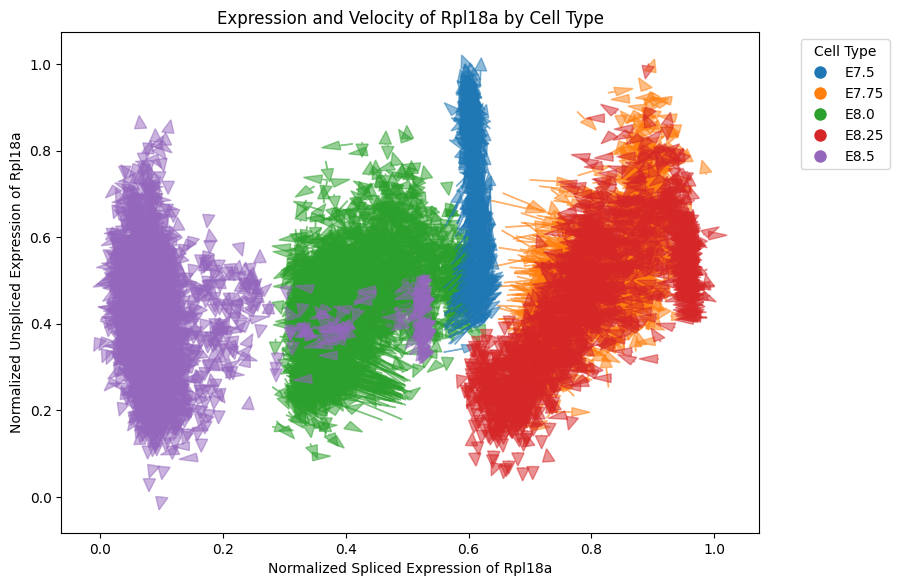

In [22]:
plot_phase_plane(adata, "Rpl18a", dataset_name, 11, 
                 u_scale=0.1, s_scale=0.1, cell_type_key="stage",
                 save_path="plots/plot2.png")

Plot saved to plots/plot2.png


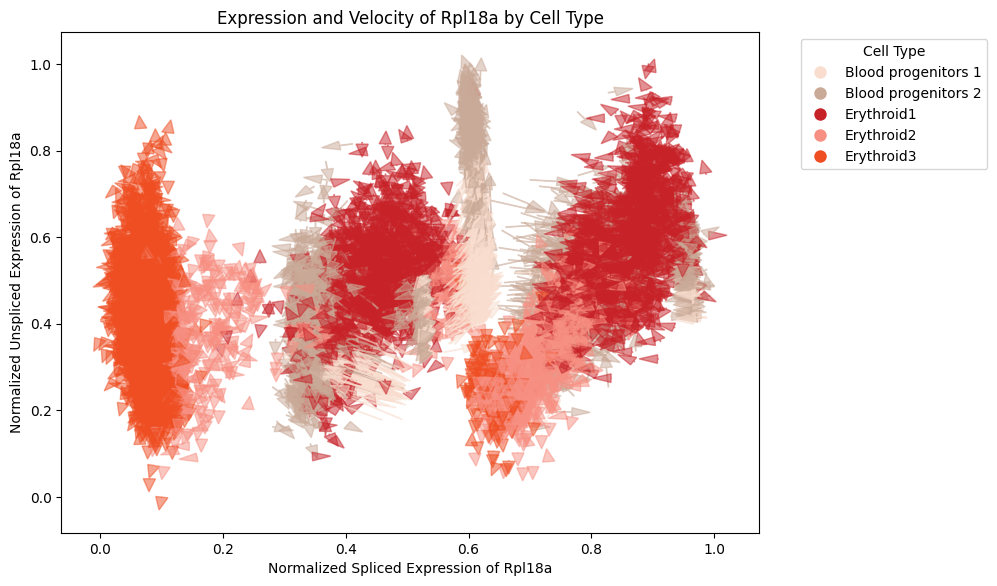

In [21]:
plot_phase_plane(adata, "Rpl18a", dataset_name, 11, 
                 u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                 save_path="plots/plot2.png")

Plot saved to plots/plot2.png


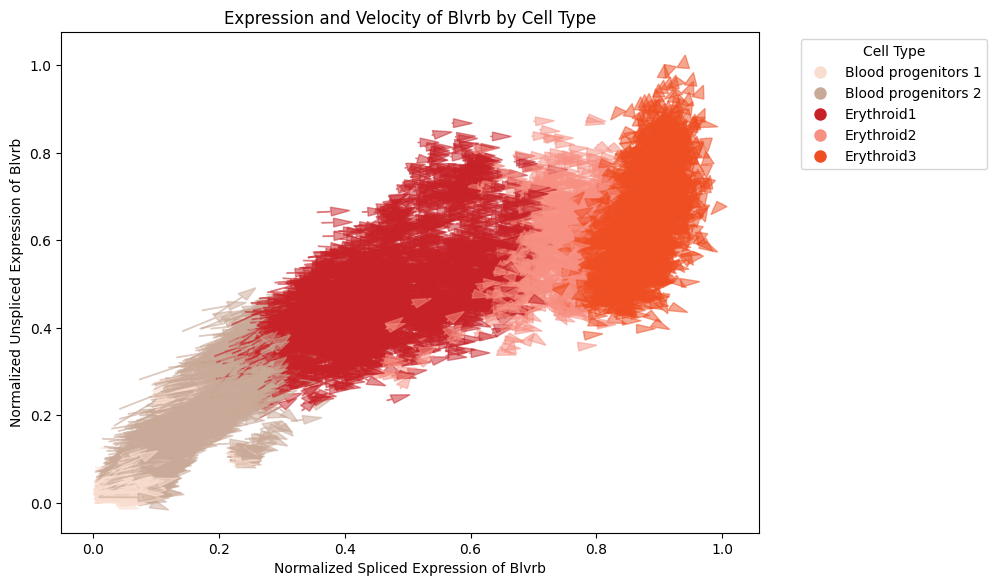

In [12]:
plot_phase_plane(adata, "Blvrb", dataset_name, 11, 
                 u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                 save_path="plots/plot2.png")

Plot saved to plots/plot2.png


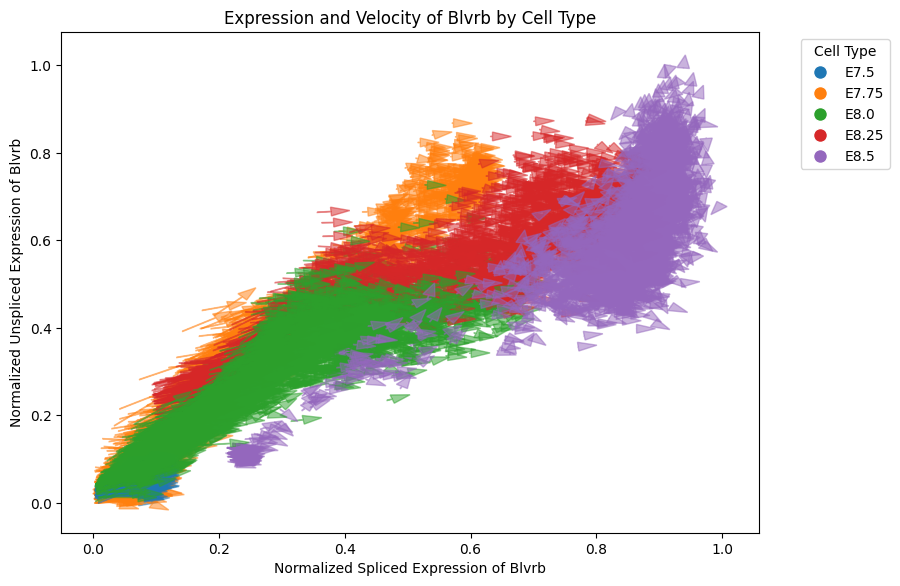

In [23]:
plot_phase_plane(adata, "Blvrb", dataset_name, 11, 
                 u_scale=0.1, s_scale=0.1, cell_type_key="stage",
                 save_path="plots/plot2.png")

Plot saved to plots/plot2.png


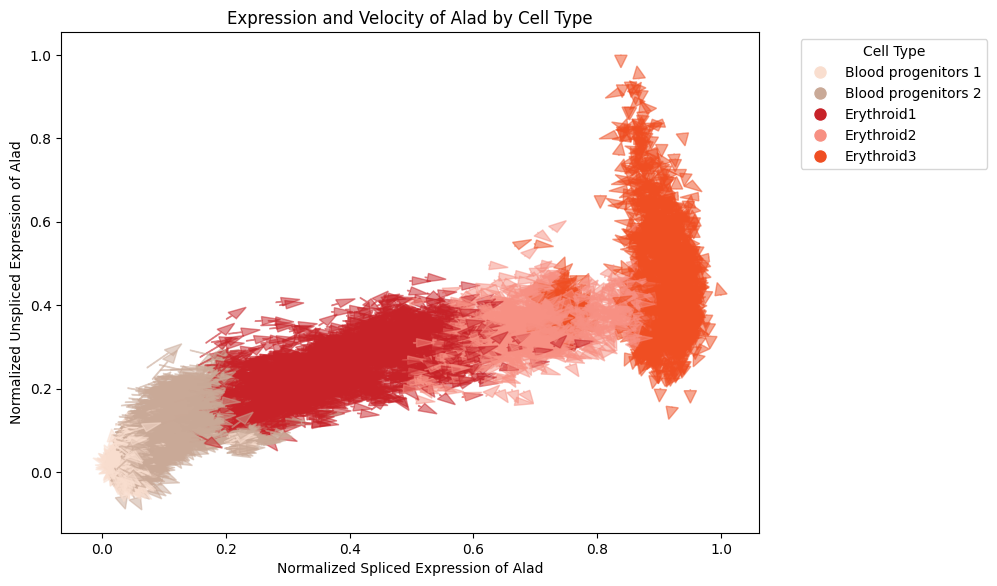

In [13]:
plot_phase_plane(adata, "Alad", dataset_name, 11, 
                 u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                 save_path="plots/plot2.png")

In [25]:
#adata.write_h5ad("res_gastr.h5ad")

Plot saved to plots/plot2.png


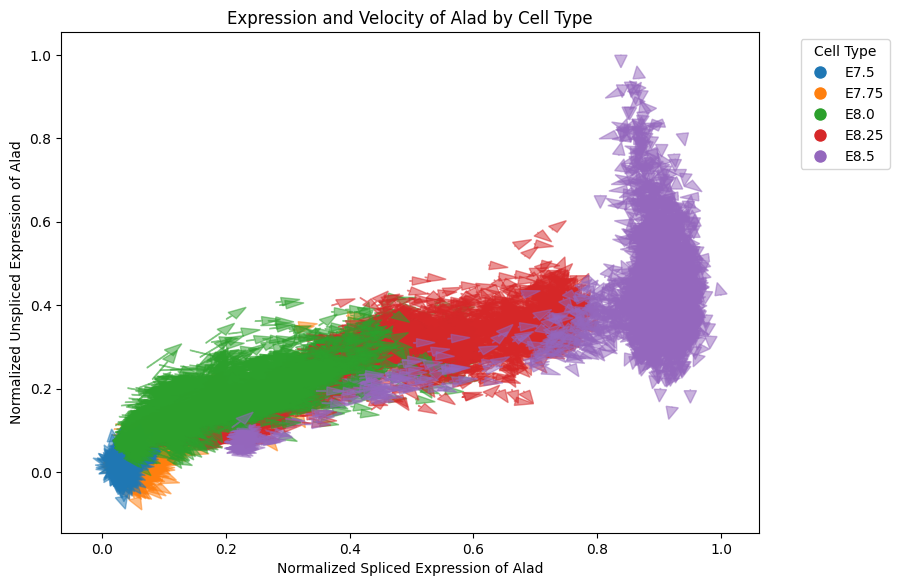

In [24]:
plot_phase_plane(adata, "Alad", dataset_name, 11, 
                 u_scale=0.1, s_scale=0.1, cell_type_key="stage",
                 save_path="plots/plot2.png")

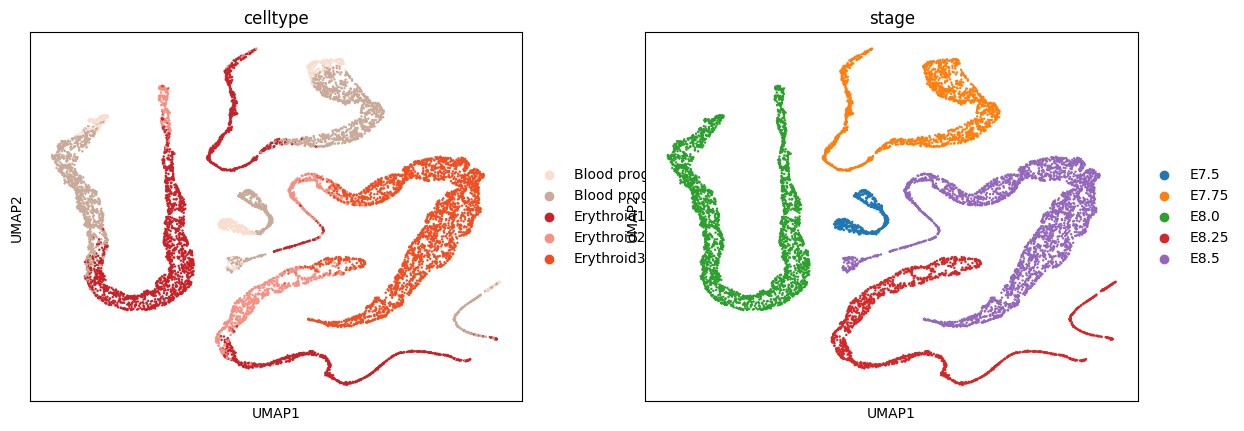

In [18]:
sc.pp.neighbors(adata, use_rep="pred")
sc.tl.umap(adata)
sc.pl.umap(adata, color=[cell_type_key, "stage"])

In [ ]:
adata.obsm[""] 
sc.pp.neighbors(adata, use_rep="velocity")
sc.tl.umap(adata)
sc.pl.umap(adata, color=[cell_type_key, "stage"])

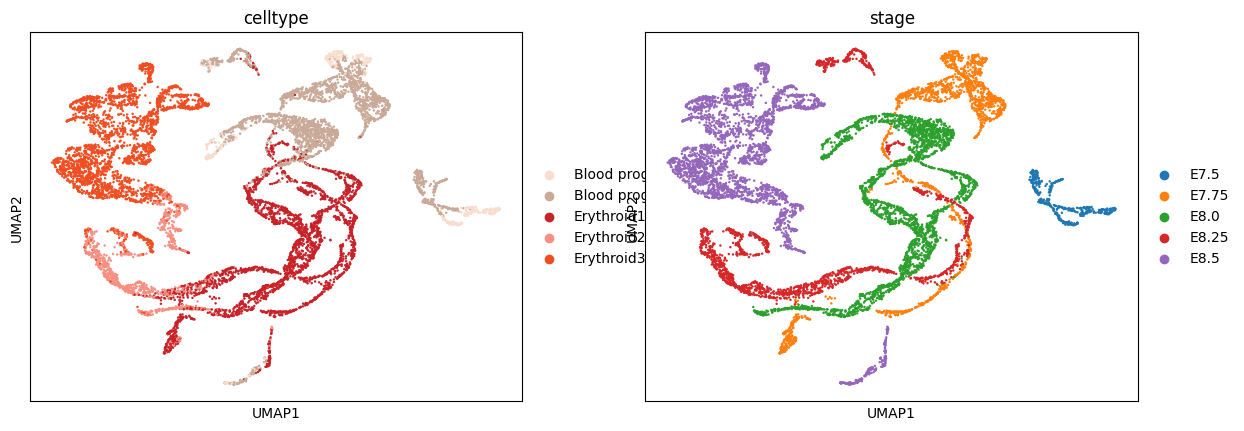

In [20]:
adata.obsm["velocity"] = adata.layers["velocity"]
sc.pp.neighbors(adata, use_rep="velocity")
sc.tl.umap(adata)
sc.pl.umap(adata, color=[cell_type_key, "stage"])

In [ ]:
sc.pp.neighbors(adata, use_rep="pred")
sc.tl.umap(adata)
sc.pl.umap(adata, color=[cell_type_key, "stage"])

In [ ]:
Isomap()

In [14]:
sc.pl.scatter(adata, x="isomap_1", y="Gnao1", layers="Mu", color="clusters")

ValueError: `x`, `y`, and potential `color` inputs must all come from either `.obs` or `.var`

In [ ]:
sc.pl.scatter(adata, x="isomap_1", y="Gnao1", layers="velocity_u", color="clusters")

In [ ]:
plot_phase_plane(adata, "Gnao1", dataset_name, 11, u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key)

In [ ]:
plot_phase_plane(adata, "Gnas", dataset_name, 11, u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key)

In [ ]:
#adata.write_h5ad("pancreas_goodresult.h5ad")